<h1>Title: Building a Machine Learning pipeline to predict Covid-19 mortality rates.</h1>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from pymongo import MongoClient

In [2]:
# Connect to MongoDB
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client['covid_db']
collection = db['covid_data']

# Load the data from CSV and store it in MongoDB
df = pd.read_csv('./covid_data.csv')
data_dict = df.to_dict(orient='records')
collection.insert_many(data_dict)

# Retrieve the data from MongoDB
data_from_db = list(collection.find())
df = pd.DataFrame(data_from_db)

In [3]:
df.columns

Index(['_id', 'iso_code', 'continent', 'location', 'date', 'total_cases',
       'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate',
       'icu_patients', 'hosp_patients', 'weekly_icu_admissions',
       'weekly_hosp_admissions', 'total_tests', 'new_tests', 'positive_rate',
       'tests_per_case', 'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'total_boosters', 'new_vaccinations',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'handwashing_facilities',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

In [4]:
df.describe

<bound method NDFrame.describe of                              _id iso_code continent     location        date  \
0       66327d8661d6e117f49463b5      AFG      Asia  Afghanistan   2/24/2020   
1       66327d8661d6e117f49463b6      AFG      Asia  Afghanistan   2/25/2020   
2       66327d8661d6e117f49463b7      AFG      Asia  Afghanistan   2/26/2020   
3       66327d8661d6e117f49463b8      AFG      Asia  Afghanistan   2/27/2020   
4       66327d8661d6e117f49463b9      AFG      Asia  Afghanistan   2/28/2020   
...                          ...      ...       ...          ...         ...   
457981  663301de1cc0734d4a34f21e      ZWE    Africa     Zimbabwe  10/20/2022   
457982  663301de1cc0734d4a34f21f      ZWE    Africa     Zimbabwe  10/21/2022   
457983  663301de1cc0734d4a34f220      ZWE    Africa     Zimbabwe  10/22/2022   
457984  663301de1cc0734d4a34f221      ZWE    Africa     Zimbabwe  10/23/2022   
457985  663301de1cc0734d4a34f222      ZWE    Africa     Zimbabwe  10/24/2022   

     

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame containing the dataset

# Selecting features and target
features = ['total_cases', 'total_deaths', 'icu_patients', 'hosp_patients',
            'total_tests', 'total_vaccinations', 'stringency_index',
            'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
            'gdp_per_capita', 'handwashing_facilities', 'hospital_beds_per_thousand',
            'life_expectancy', 'human_development_index', 'population']
X = df[features]
y = df['new_deaths']

df_clean = df.dropna(subset=['new_deaths'])

# Selecting features and target again after cleaning
features = ['total_cases', 'total_deaths', 'icu_patients', 'hosp_patients',
            'total_tests', 'total_vaccinations', 'stringency_index',
            'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
            'gdp_per_capita', 'handwashing_facilities', 'hospital_beds_per_thousand',
            'life_expectancy', 'human_development_index', 'population']
X = df_clean[features]
y = df_clean['new_deaths']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score


# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
explained_var_rf = explained_variance_score(y_test, y_pred_rf)
print("\nRandom Forest:")
print("Mean Absolute Error:", mae_rf)
print("R-squared:", r2_rf)
print("Explained Variance Score:", explained_var_rf)

# Gradient Boosting Pipeline
gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
explained_var_gb = explained_variance_score(y_test, y_pred_gb)
print("\nGradient Boosting:")
print("Mean Absolute Error:", mae_gb)
print("R-squared:", r2_gb)
print("Explained Variance Score:", explained_var_gb)




Random Forest:
Mean Absolute Error: 13.151211762690757
R-squared: 0.990194045297925
Explained Variance Score: 0.990209860097886

Gradient Boosting:
Mean Absolute Error: 63.87412410366199
R-squared: 0.8925019694331398
Explained Variance Score: 0.8925036181127628


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

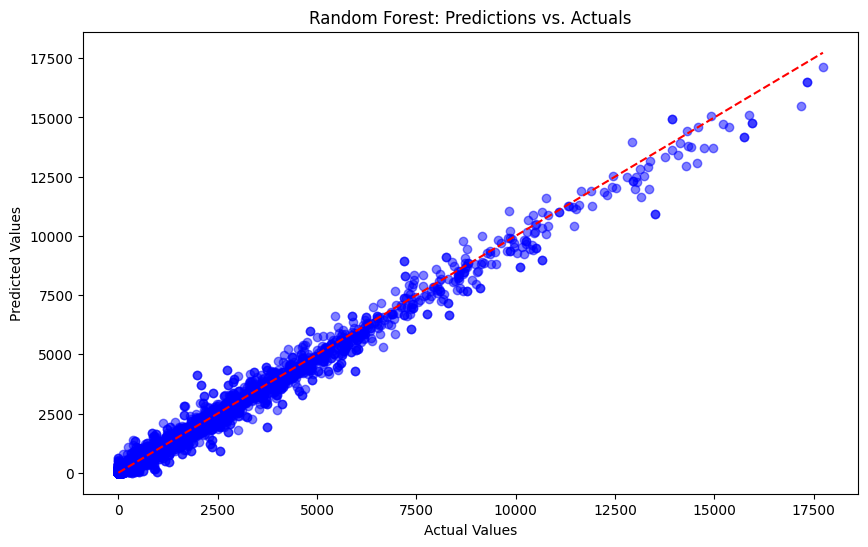

In [8]:
# Visualizing Predictions vs. Actuals for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Random Forest: Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()



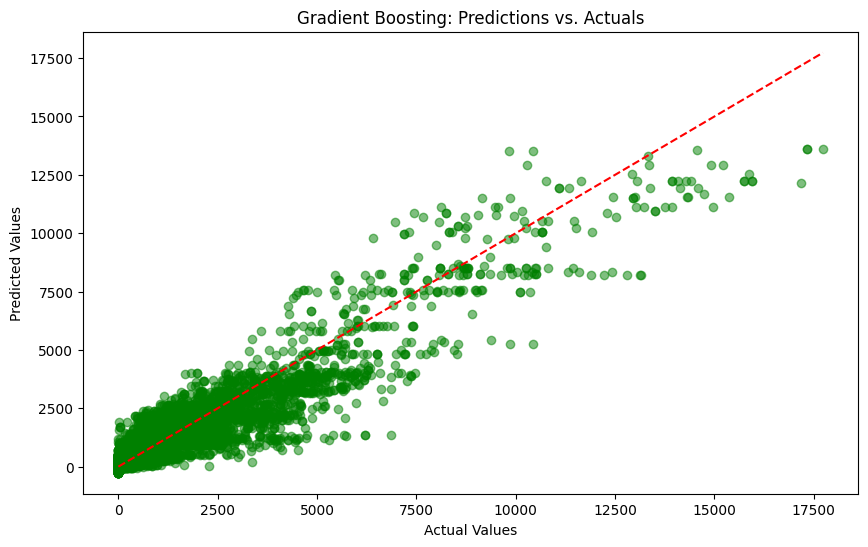

In [9]:
# Visualizing Predictions vs. Actuals for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Gradient Boosting: Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()



In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression


# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
explained_var_xgb = explained_variance_score(y_test, y_pred_xgb)
print("\nXGBoost:")
print("Mean Absolute Error:", mae_xgb)
print("R-squared:", r2_xgb)
print("Explained Variance Score:", explained_var_xgb)


XGBoost:
Mean Absolute Error: 46.3316209014068
R-squared: 0.9045519602412715
Explained Variance Score: 0.9045520416925136


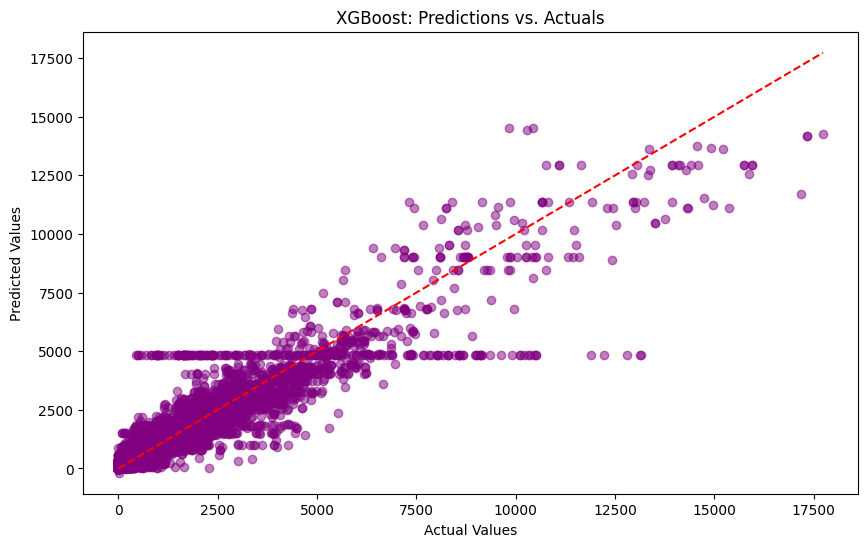

In [11]:
# Visualizing Predictions vs. Actuals for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('XGBoost: Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()